This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

## Aug, 14th 2024 Note:

* Parts of following code do not work under `river 0.21.2`.
* It results in the following error (probably caused by an typo in the `river` code):

File ~/.conda/envs/spot/lib/python3.11/site-packages/river/metrics/roc_auc.py:103, in ROCAUC.get(self)
    100     tprs[i] = safe_div(a=tp, b=tp + fn)
    101     fprs[i] = safe_div(a=fp, b=fp + tn)
--> 103 return -integrate.trapz(x=fprs, y=tprs)

AttributeError: module 'scipy.integrate' has no attribute 'trapz'

# Chapter 6: Special Requirements for OML Methods

# Outlier Detection using One-Class SVM

In [1]:
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing


## Model: OneClassSVM

* Initialization of the one-class SVM with the following parameters:
  * `nu`: an upper bound on the proportion of training errors and a lower bound on the proportion of support vectors. The value can be interpreted as the expected proportion of anomalies. Thus, in our example, 20% anomalies are expected.
* For the quantile filter a value of `q=0.995` is chosen. This is the quantile above which an anomaly value is classified as an outlier.

In [2]:
model = anomaly.QuantileFilter(
     anomaly.OneClassSVM(nu=0.002),
     q=0.995
 )

## The CreditCard dataset

* The CreditCard dataset contains credit card transactions from European cardholders in September 2013. 
* This dataset represents transactions that occurred within two days, where we have 492 fraud cases out of 284,807 transactions. 
* The dataset is unbalanced: 
  * The positive class (fraud) represents 0.172% of all transactions.

## Metric ROC AUC

* The ROC AUC (Receiving Operating Characteristic Area Under the Curve) is chosen as the metric because the data set is highly unbalanced and Accuracy, which would otherwise be used, would give a biased result.

In [3]:
auc = metrics.ROCAUC()

## Test and train the model:

* Only the first 2500 data sets are used for demonstration purposes.

In [4]:
for x, y in datasets.CreditCard().take(2500):
    score = model.score_one(x)
    is_anomaly = model.classify(score)
    model.learn_one(x)
    auc.update(y, is_anomaly)

auc

Uncompressing into /home/tbartzbe/river_data/CreditCard


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

# Example: UnbalancedData

* In machine learning, imbalanced data is a common occurrence. 
* This is especially true for OML for tasks such as fraud detection and spam classification.
* In these two cases, which are binary classification problems, there are usually many more negative events (`0`) than positive ones (`1`). 
* As an example, we use the `California Housing` dataset with the parameter `percentile_0 = 95`, i.e. 95% of the entries are `0` (`False`).
* We will first use a `Collection.Counter` to count the number of 0s and 1s to check the class split.

In [45]:
import collections
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import stream
import pandas as pd

In [46]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def get_features():
    california_housing = fetch_california_housing()
    return california_housing.feature_names

def get_dataset():
    california_housing = fetch_california_housing()
    features = california_housing.feature_names
    X = pd.DataFrame(california_housing.data, columns=features)
    y = pd.Series(california_housing.target)
    ## compute the 95% percentile of the target variable y
    y_95 = y.quantile(0.75)
    print(f"y_95: {y_95}")
    y = y.apply(lambda x: 1 if x > y_95 else 0)
    dataset = stream.iter_pandas(X, y)
    return dataset

In [47]:
counts = collections.Counter(y for _, y in get_dataset())
for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

y_95: 2.6472499999999997
1: 5160 (25.00000%)
0: 15480 (75.00000%)


* The data set is unbalanced. 
* As a starting point, we train a logistic regression model with standard parameters.
* We will measure the ROC AUC score, as Accuracy is not a suitable metric for unbalanced data.

In [48]:
from river import compose, preprocessing, linear_model, optim

features = get_features()

model = (compose.Select(*features) |
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression()
)

metric = metrics.ROCAUC()
evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

## Unbalanced Data: Importance weighting to handle unbalanced data.

* Performance is already acceptable, but can be improved.
* The first thing we can do is to increase the proportion of `1` weights by using the `weight_pos` argument of the `log` loss function.

In [49]:
from river import optim

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(
        loss=optim.losses.Log(weight_pos=5)
    )
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

### Unbalanced Data: Focal Loss

* [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) is applied next:

In [50]:
model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(loss=optim.losses.BinaryFocalLoss(2, 1))
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

### Unbalanced Data: Undersampling (of majority class). 

* Adding weights only works with gradient-based models (including neural networks). 
* A more generic and potentially more effective approach is to use undersampling and oversampling. 
* As an example, we undersample the stream so that our logistic regression gets 20% of `1`s and 80% of `0` values. 
* Under-sampling has the added benefit of requiring fewer training steps and thus reduces overall training time.

In [51]:
from river import preprocessing, imblearn, linear_model, metrics, evaluate, stream

model = (
    preprocessing.StandardScaler() |
    imblearn.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

* The `RandomunderSampler` class is a wrapper for classifiers. 
* This is represented by a rectangle around the logistic regression class when we visualize the model.

In [52]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  RandomUnderSampler (
    classifier=LogisticRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Log (
        weight_pos=1.
        weight_neg=1.
      )
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    desired_dist={0: 0.8, 1: 0.2}
    seed=42
  )
)

## Unbalanced data: Over-sampling (of the minority class).

* We can also achieve the same class distribution by increasing the size of the minority class. 
* This for additional cost for training, since more samples are used.

In [53]:
model = (
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

## Unbalanced data: sampling with the desired sample size.

* The disadvantage of both undersampling and oversampling is that we have no control over the amount of data the classifier trains on. 
* The number of samples is adjusted to achieve the target distribution either by reducing or adding.

* However, we can do both at the same time and choose how many samples the classifier gets.
* For this purpose, we can use the `RandomSampler` class. 
* In addition to the desired class distribution, we can specify how much data to train. 
* The samples are both reduced and multiplied.
* This is powerful because you can control both the class distribution and the size of the training data (and thus the training time). 
* In the following example, we set `sampling_rate=0.1` so that the model trains with 10 percent of the data.

In [54]:
model = (
    preprocessing.StandardScaler() |
    imblearn.RandomSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: 0.8, 1: 0.2},
        sampling_rate=.01,
        seed=42
    )
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

## Unbalanced Data: A hybrid approach

* The methods can also be combined.
* Here we combine `RandomUnderSampler` and the parameter `weight_p` from the function `optim.Losses.log`:

In [55]:
model = (
    preprocessing.StandardScaler() |
    imblearn.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(
            loss=optim.losses.Log(weight_pos=5)
        ),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

evaluate.progressive_val_score(get_dataset(), model, metric)

y_95: 2.6472499999999997


AttributeError: module 'scipy.integrate' has no attribute 'trapz'

# Large number of variables: SelectKBest

* The `SelectKBest` method removes all but the $k$ best features from a dataset.
* A similarity measure is calculated for the features.

In [56]:
from pprint import pprint
from river import feature_selection
from river import stats
from river import stream
from sklearn import datasets

## Data

* We create a random regression problem using the `sklearn` method `datasets.make_regression`.
* The model uses 10 features. The number of informative features, i.e. the number of features used to build the linear model, is specified by the `n_informative` parameter and is two in our case.

In [57]:
X, y = datasets.make_regression(
     n_samples=100,
     n_features=10,
     n_informative=2,
     random_state=1
 )

## Definition of the SelectKBest selector.

* The parameter `k` of the method `SelectKBest` defines how many features should be kept.
* The Pearson correlation is chosen as the similarity metric.

In [58]:
selector = feature_selection.SelectKBest(
     similarity=stats.PearsonCorr(),
     k=2
 )

## Train the selector 

* After the selector has been trained with the data, the leaderboard can be displayed.

In [59]:
for xi, yi, in stream.iter_array(X, y):
     selector.learn_one(xi, yi)
pprint(selector.leaderboard)

Counter({1: 0.7757127118501904,
         9: 0.5245064418011397,
         5: 0.06238414488940968,
         7: -0.07256452234434604,
         3: -0.08680305162688622,
         2: -0.09267757132244953,
         6: -0.09821799786597549,
         0: -0.1303288592506864,
         8: -0.1484329575449028,
         4: -0.15486245536178062})


* Anschließend können die `k` (hier 2) besten Merkmale ausgewählt werden.

In [60]:
selector.transform_one(xi)

{1: 1.5433591108044837, 9: 0.8360047194342688}

# Large number of variables: Poisson Inclusion

* The `PoissonInclusion` procedure randomly decides whether a new feature is added. 
* When a new feature is encountered, it is selected with probability $p$. 
* The frequency with which a feature must be seen before it is added to the model, 
follows a geometric distribution with expected value $1/p$.
* This feature selection method should be used when there are a very large number of features, only a few of which are 
are useful, i.e., in situations with "sparse features".

In [61]:
from river import datasets
from river import feature_selection
from river import stream


## The Data Set: TrumpApproval 

* FiveThirtyEight is a U.S. news website (editor-in-chief is Nate Silver) focused on statistics and data journalism. 
* The TrumpApproval dataset is based on data used by FiveThirtyEight to analyze Donald Trump's approval ratings. 
  * It contains five features that are approval ratings collected by five polling organizations. 
* The target variable is the approval rating from FiveThirtyEight's model.

In [62]:
dataset = iter(datasets.TrumpApproval())
feature_names = next(dataset)[0].keys()
feature_names

dict_keys(['ordinal_date', 'gallup', 'ipsos', 'morning_consult', 'rasmussen', 'you_gov'])

* Now `PoissonInclusion` is executed incrementally for the dataset.
* When all five features have been selected, the procedure is terminated and the number of steps is indicated.

In [63]:
selector = feature_selection.PoissonInclusion(p=0.1, seed=1)
n = 0
while True:
    x, y = next(dataset)
    xt = selector.transform_one(x)
    if xt.keys() == feature_names:
        break
    n += 1

print(f"Anzahl der Schritte, bis alle Merkmale gefunden wurden: {n}")
feature_names
xt.keys()

Anzahl der Schritte, bis alle Merkmale gefunden wurden: 9


dict_keys(['ordinal_date', 'gallup', 'ipsos', 'morning_consult', 'rasmussen', 'you_gov'])

# Large number of variables: VarianceThreshold

* This method removes features with low variance.
* The minimum required variance of a feature is controlled by the `threshold` parameter:
  * The default `threshold` value is `0`.

In [64]:
from river import feature_selection
from river import stream


## A simple data set

* We use a simple data set with four features. 
* The first and third features have only identical values and thus zero variance.

In [65]:
X = [
    [0, 2, 0, 3],
    [0, 1, 4, 3],
    [0, 1, 1, 3]
]

selector = feature_selection.VarianceThreshold(threshold=0)

* In the end, only the second and third components are considered because their variance is greater than 0.

In [66]:
for x, _ in stream.iter_array(X):
    # Before 0.21.0:
    # print(selector.learn_one(x).transform_one(x))
    # After 0.21.0:
    selector.learn_one(x)
    y = selector.transform_one(x)
    print(f"y: {y}")

y: {0: 0, 1: 2, 2: 0, 3: 3}
y: {1: 1, 2: 4}
y: {1: 1, 2: 1}


# Interpretability and explainability

## Example: Interpretability

* This example shows how to perform time series modeling using radial basis functions (RBFs).
  * The quadratic-exponential kernel is used for local modeling.
  * Thus, the influence of individual time components (days, weeks, ...) on the target variable can be estimated.
  * Thus, the explanatory power of the model is improved.
* The representation in this example is experimental and serves to show the concept ("prrof-of-concept").

In [67]:
%matplotlib inline

In [68]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import stream
import datetime as dt
import pandas as pd
from datetime import datetime,timedelta
import numpy as np

## Daten: California Housing zur Regreesion

* First, we load the California Housing dataset:

In [69]:
from sklearn.datasets import fetch_california_housing
import pandas as pd


california_housing = fetch_california_housing()
features = california_housing.feature_names
x = pd.DataFrame(california_housing.data, columns=features)

* Since the original California Housing data does not have a time stamp, we are adding this.
  * The start date is January 1, 1975.
* For control purposes, we output the first three time stamps.

In [70]:
start = datetime(1975, 1, 1)
tag ={}
for day in range(0, x.index.max()+1): 
   tag[day] = start+timedelta(days=day)
   
for k, v in tag.items():
    if  k<3:
        print(k, v)

0 1975-01-01 00:00:00
1 1975-01-02 00:00:00
2 1975-01-03 00:00:00


* The first features now have the following shape:

In [71]:
x['moment'] = pd.Series(tag)
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,moment
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,1975-01-01
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1975-01-02
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,1975-01-03
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,1975-01-04
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,1975-01-05


In [72]:
# y = pd.Series(np.ravel(dataset.data.target))
y = pd.Series(california_housing.target)
dataset = stream.iter_pandas(x, y)

* The method `toordinal` returns the proleptic Gregorian ordinal number (the 1st of January of the year 1 is the day 1 and all dates before this day are then called proleptically dated. They have negative year numbers respectively are described with "before the reckoning of time" and similar terms).

In [73]:
def get_ordinal_date(x):
    return {'ordinal_date': x['moment'].toordinal()}

## Model: Linear Regression

* We define a pipeline that uses the ordinal datum and transforms the data to mean zero and standard deviation one using `StandardScaler`.
* A linear regression model is created using this preprocessed data.

In [74]:
model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)
model

Pipeline (
  FuncTransformer (
    func="get_ordinal_date"
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

## The method `evaluate_plot_model`.

* We define a method to visualize the original data as well as the data predicted by the model.

In [75]:
from river import metrics
from river import utils
import matplotlib.pyplot as plt

def evaluate_plot_model(model): 
    metric = utils.Rolling(metrics.MAE(), 7)
    dates = []
    y_trues = []
    y_preds = []
    i = 0 # ZCounter: days per year
    for x, y in dataset:

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x['moment'])
        y_trues.append(y)
        y_preds.append(y_pred)
        
        i = i +1
        if i > 365:
            break

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=2, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=2, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

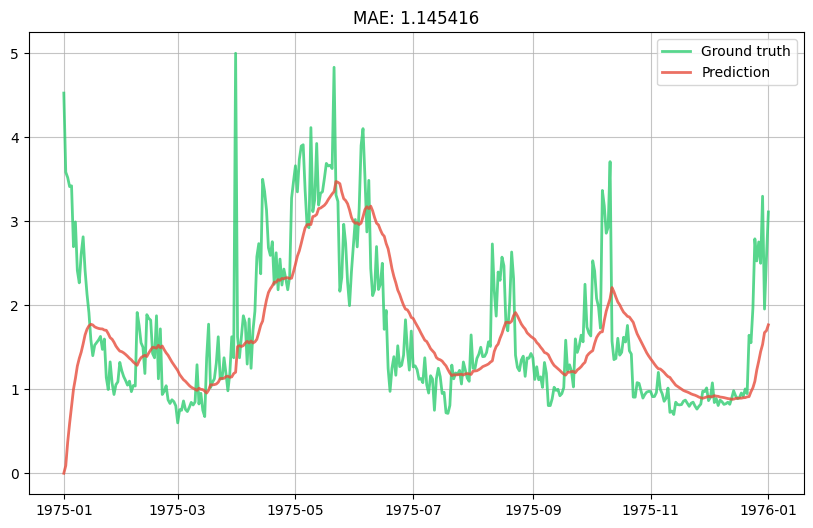

In [76]:
evaluate_plot_model(model)

### 2nd attempt with explicit specification of `intercept_lr`.

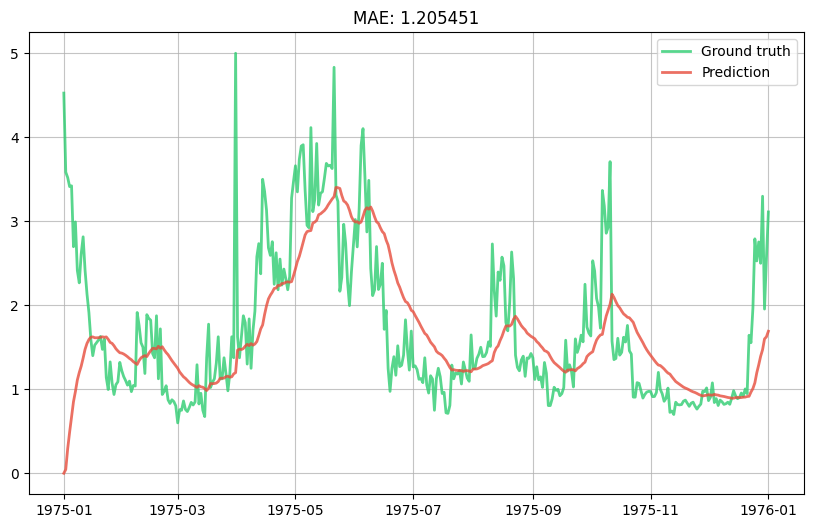

In [77]:
from river import stats

dataset = stream.iter_pandas(x, y)
model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(intercept_lr=.005)),
)

#model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_plot_model(model)

## Hinzunahme der Information über den Monat

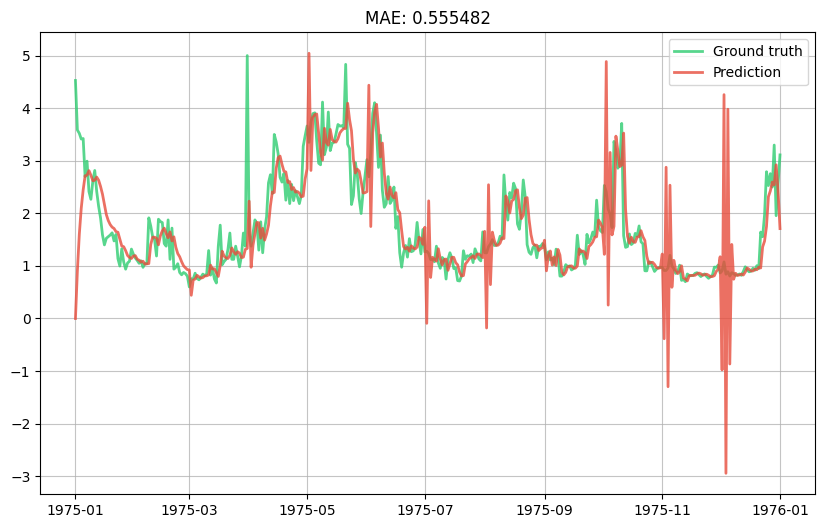

In [78]:
import calendar

dataset = stream.iter_pandas(x, y)
def get_month(x):
    return {
        calendar.month_name[month]: month == x['moment'].month
        for month in range(1, 13)
    }


model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(intercept_lr=.1))
)
evaluate_plot_model(model)


* Illustration of the contributions (effects) of the individual months:

In [79]:
model['lin_reg'].weights


{'January': 0.04368781598726312,
 'February': -0.0824293947487647,
 'March': 0.12890946743134882,
 'April': 0.0666040474184442,
 'May': 0.05324230124264326,
 'June': -0.08748757046013607,
 'July': -0.11869046068300036,
 'August': -0.05260383969002352,
 'September': -0.002421941876844952,
 'October': -0.10075460785962076,
 'November': -0.08129024315486971,
 'December': 0.1622377575794612,
 'ordinal_date': 0.12254773098558576}

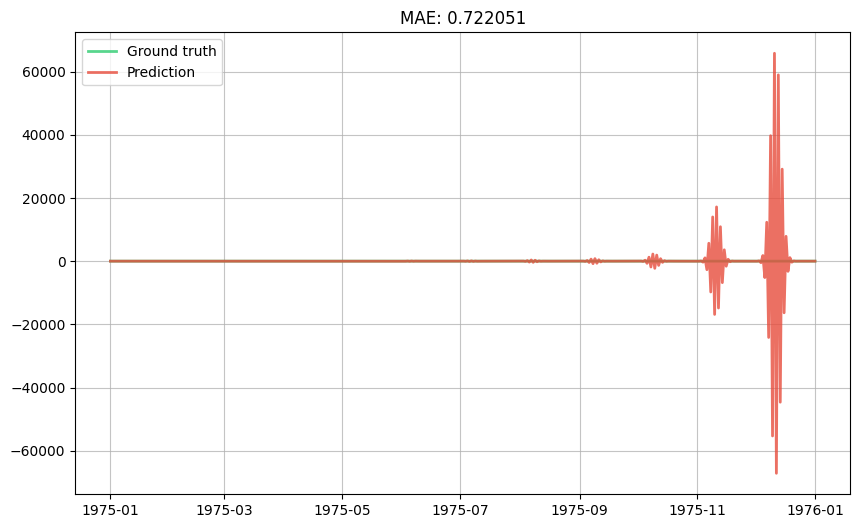

In [80]:
from river import optim

dataset = stream.iter_pandas(x, y)

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03)
    ))
)
evaluate_plot_model(model)


## Application of a kernel function

* We do not use the simple distances, but weight them by means of a kernel function:
  * We use the quadratic-exponential kernel, so `math.exp(-((x['moment'].day % 2 - day) ** 2 ) / sigma)`

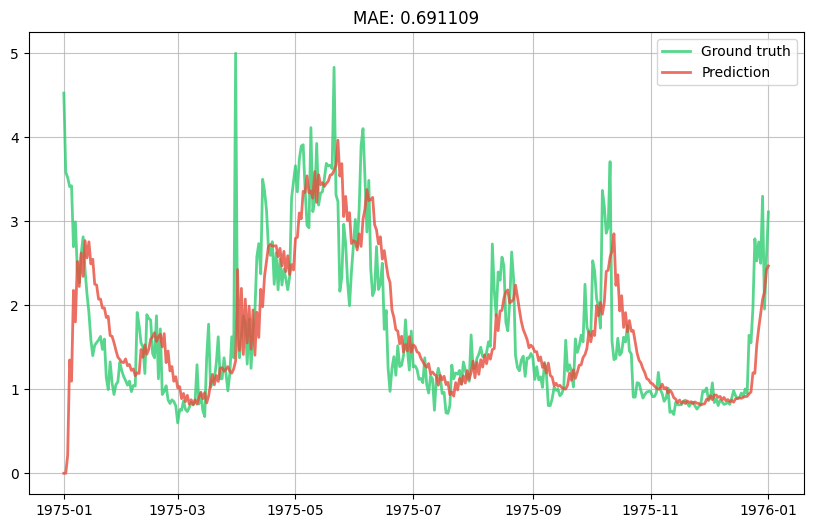

In [81]:
import math

dataset = stream.iter_pandas(x, y)
sigma = 1e-6

def get_month_distances(x):
    #print(x['moment'].day % 7)
    return {
        calendar.day_name[day]: math.exp(-((x['moment'].day % 2 - day) ** 2 ) / sigma)
        for day in range(0,2)
    }

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month_distances', compose.FuncTransformer(get_month_distances)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03)
    ))
)
evaluate_plot_model(model)


## Further Considerations:
  
* The California Housing dataset was used only to demonstrate technical implementation.
  * It would make more sense to use a dataset that implicitly includes seasonal effects (e.g., airpassenger).
* A transformation of the target, e.g. via `model = preprocessing.TargetStandardScaler(regressor=model)`, is sometimes helpful.

# StatImputer

* A simple example demonstrating the use of the class 'StatImputer'.
* Using a simple data set, mean imputation is demonstrated.

In [82]:
from river import preprocessing
from river import stats

## Data

* The fourth measured value is missing (is 'None') and is to be replaced by the mean value.

In [83]:
X = [
    {'temperature': 1},
    {'temperature': 8},
    {'temperature': 3},
    {'temperature': None},
    {'temperature': 4}
]
X

[{'temperature': 1},
 {'temperature': 8},
 {'temperature': 3},
 {'temperature': None},
 {'temperature': 4}]

## Mean-value imputation

* After imputation, the fourth measured value is replaced by the mean value
  * $(1+8+3)/3$
* has been replaced.

In [84]:
imp = preprocessing.StatImputer(('temperature', stats.Mean()))

for x in X:
    imp.learn_one(x)
    #imp = imp.predict_one(x)
    print(imp.transform_one(x))
{'temperature': 1}
{'temperature': 8}
{'temperature': 3}
{'temperature': 4.0}
{'temperature': 4}

{'temperature': 1}
{'temperature': 8}
{'temperature': 3}
{'temperature': 4.0}
{'temperature': 4}


{'temperature': 4}